In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('data/monthly-sunspots.csv', parse_dates=[0])
df.head(10)

,Month,Sunspots
0,1749-01-01,58.0
1,1749-02-01,62.6
2,1749-03-01,70.0
3,1749-04-01,55.7
4,1749-05-01,85.0
5,1749-06-01,83.5
6,1749-07-01,94.8
7,1749-08-01,66.3
8,1749-09-01,75.9
9,1749-10-01,75.5


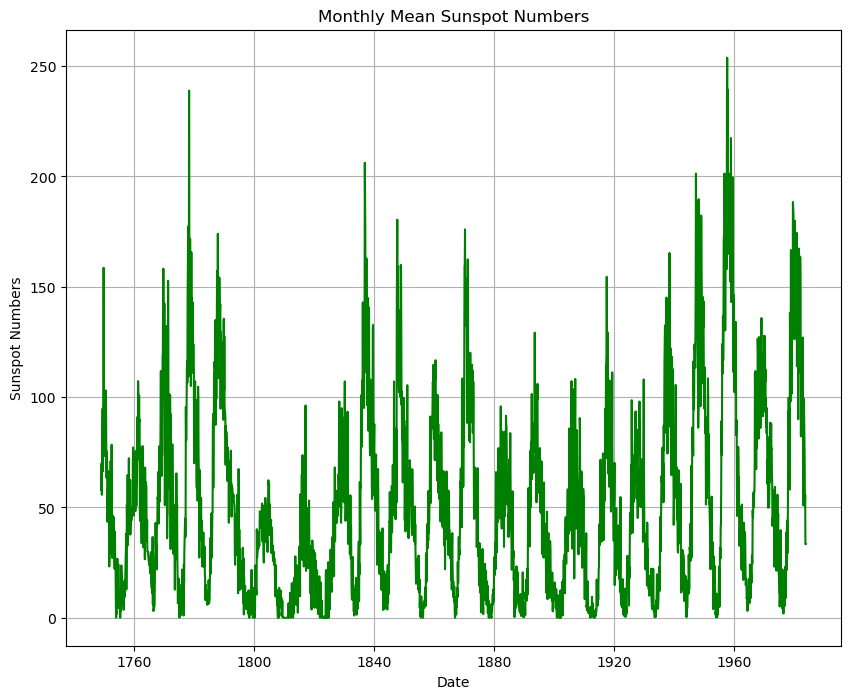

In [5]:
plt.figure(figsize=(10,8))
plt.plot(df['Month'], df['Sunspots'], color = 'green', label = 'Sunspot Numbers')
plt.xlabel('Date')
plt.ylabel('Sunspot Numbers')
plt.grid()
plt.title('Monthly Mean Sunspot Numbers')
plt.show()

In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Month,2820,1866-06-16 10:38:17.872340992,1749-01-01 00:00:00,1807-09-23 12:00:00,1866-06-16 00:00:00,1925-03-08 18:00:00,1983-12-01 00:00:00,NaN
Sunspots,2820.0,51.265957,0.0,15.7,42.0,74.925,253.8,43.448971


In [7]:
df['Month'] = pd.to_datetime(df['Month'])
data_new = df.set_index(df['Month'])
data_new = data_new.drop(labels = ['Month'], axis = 1)
data_new.head()

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


<Axes: xlabel='Month'>

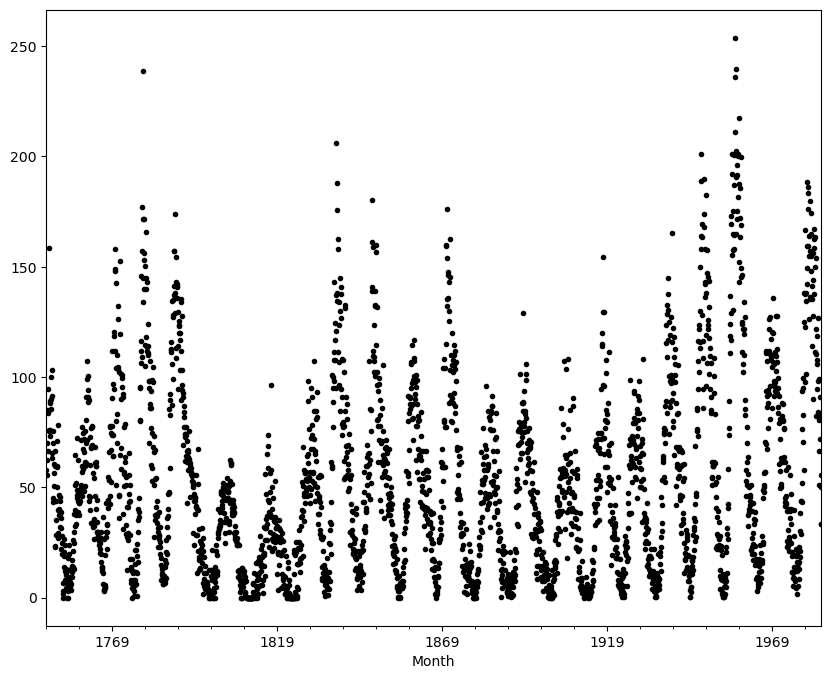

In [8]:
fig = plt.figure(figsize=(10,8))
data_new['Sunspots'].plot(style = 'k.')

In [9]:
data_q = data_new.resample('q').mean()
data_q.head()

,Sunspots
Month,
1749-03-31,63.533333
1749-06-30,74.733333
1749-09-30,79.000000
1749-12-31,106.433333
1750-03-31,79.466667


In [10]:
def adfuller_test(data):
    result = adfuller(data)
    labels = ['ADF Test Statistic' 'P-value', 'Lags Used', 'Number of Observation Used']
    for value, label in zip(result, labels):
        print(label+": "+str(value))
    if result[1] <= 0.05:
        print("Strong evidencew against the null hypothesis(h0), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

<Axes: xlabel='Month'>

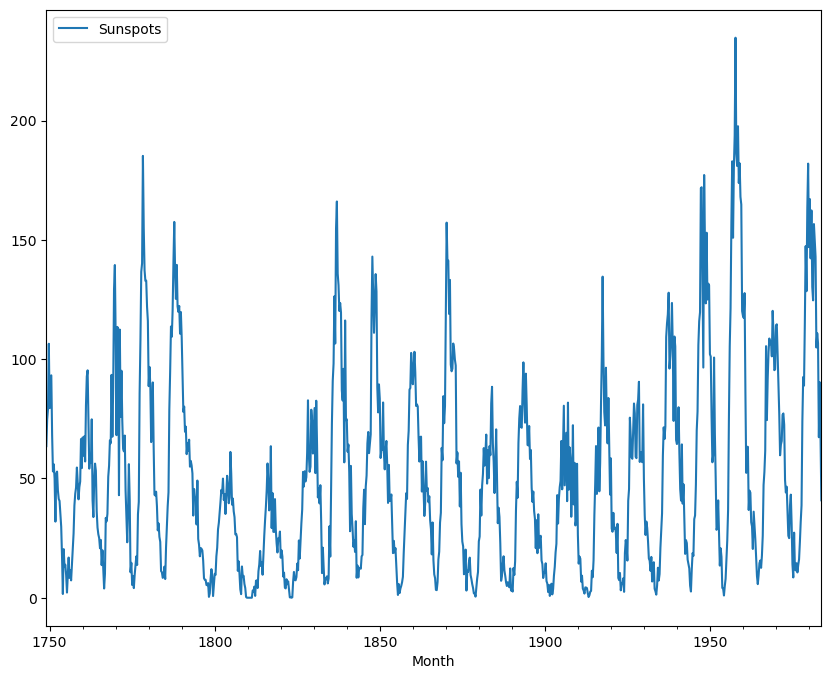

In [11]:
data_q.plot(figsize=(10,8))

In [12]:
base_data = data_q.copy()
base_data['Monthly Mean Total Sunspot Number'] = base_data['Sunspots']
base_data['Shifter Monthly Mean Total Sunspot Number'] = base_data['Monthly Mean Total Sunspot Number'].shift(1)

In [13]:
base_data.head()

,Sunspots,Monthly Mean Total Sunspot Number,Shifter Monthly Mean Total Sunspot Number
Month,,,
1749-03-31,63.533333,63.533333,NaN
1749-06-30,74.733333,74.733333,63.533333
1749-09-30,79.000000,79.000000,74.733333
1749-12-31,106.433333,106.433333,79.000000
1750-03-31,79.466667,79.466667,106.433333


<Axes: xlabel='Month'>

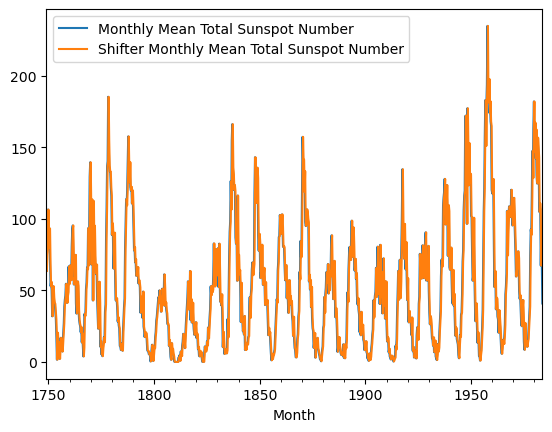

In [14]:
base_data[['Monthly Mean Total Sunspot Number', 'Shifter Monthly Mean Total Sunspot Number']].plot()

In [15]:
base_data = base_data.dropna()
print("Mean Squared Error:", mean_squared_error(base_data['Monthly Mean Total Sunspot Number'], 
                                                base_data['Shifter Monthly Mean Total Sunspot Number']))

Mean Squared Error: 238.70118210862617


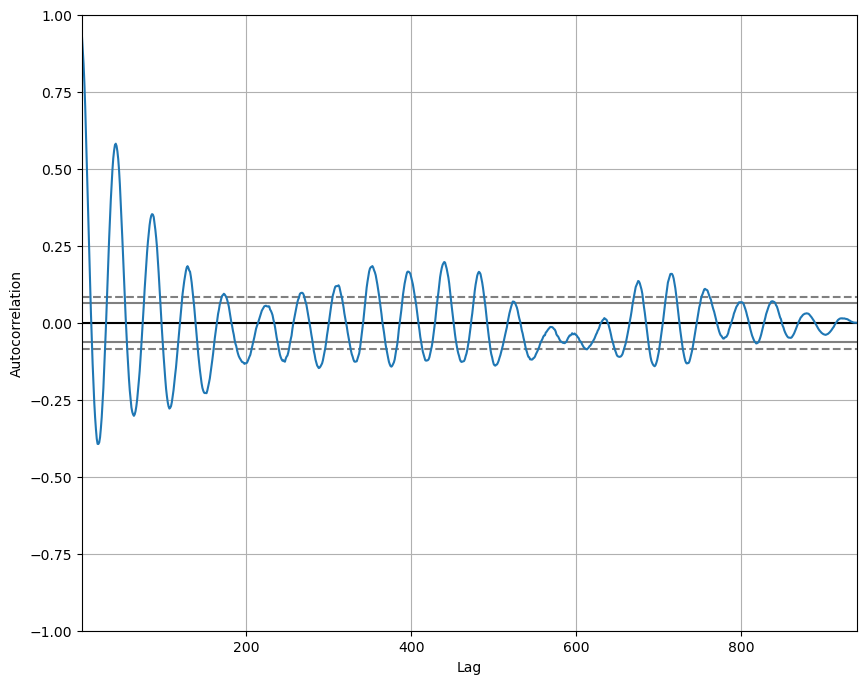

In [16]:
fig = plt.figure(figsize=(10,8))
autocorrelation_plot(data_q)
plt.show()

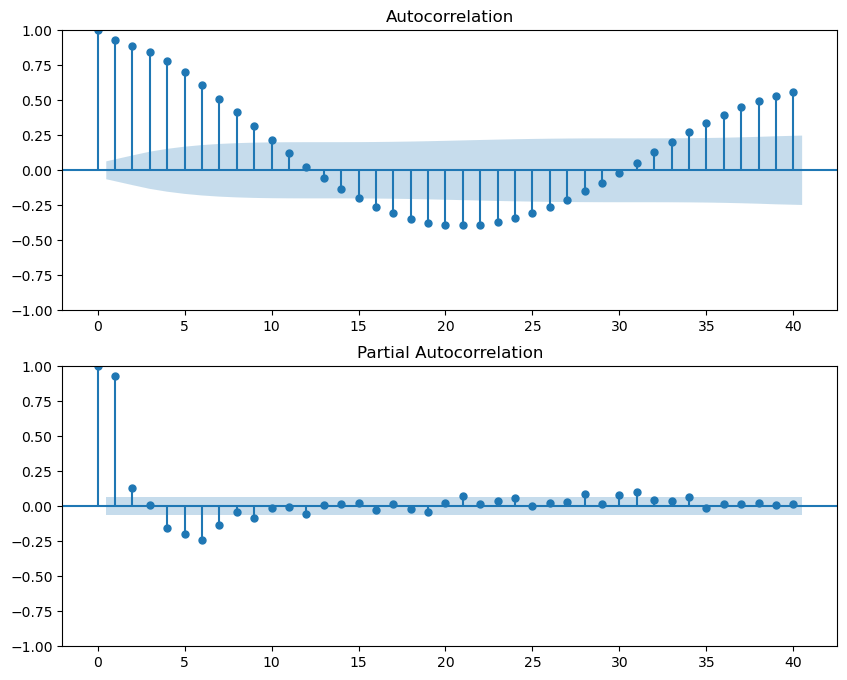

In [17]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_q, lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_q, lags = 40, ax = ax2)

In [18]:
model = sm.tsa.statespace.SARIMAX(data_q['Sunspots'], order=(2,0,2), seasonal_order=(2,0,2,6))
results = model.fit()

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          Sunspots   No. Observations:                  940
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 6)   Log Likelihood               -3859.945
Date:                           Mon, 05 May 2025   AIC                           7737.891
Time:                                   20:46:29   BIC                           7781.504
Sample:                               03-31-1749   HQIC                          7754.516
                                    - 12-31-1983                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7891      0.077     23.342      0.000       1.639       1.939
ar.L2         -0.7905      0.077    -10.291      0.000      -0.941      -0.640
ma.L1         -1.1070      0.074    -15.046      0.000      -1.251      -0.963
ma.L2          0.3436      0.025     13.758      0.000       0.295       0.393
ar.S.L6        1.2732      0.043     29.540      0.000       1.189       1.358
ar.S.L12      -0.9216      0.043    -21.339      0.000      -1.006      -0.837
ma.S.L6       -1.2804      0.053    -24.361      0.000      -1.383      -1.177
ma.S.L12       0.8761      0.051     17.109      0.000       0.776       0.976
sigma2       214.4559      7.292     29.410      0.000     200.164     228.748
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):               129.40
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Month'>

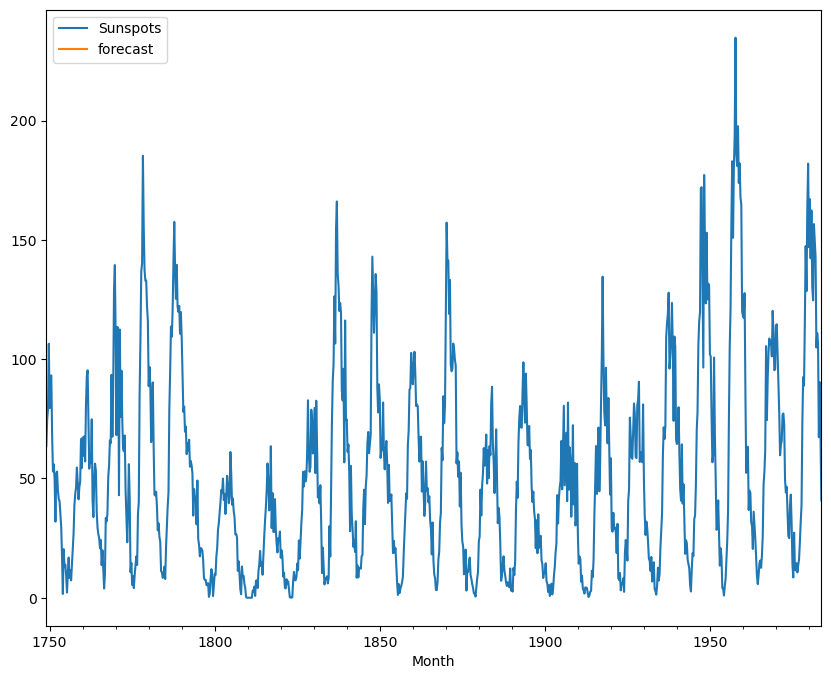

In [20]:
data_q['forecast'] = results.predict(start = 1000, end = 1084, dynamic = True)
data_q[['Sunspots', 'forecast']].plot(figsize = (10,8))